**Here, the dataset that I used for the Feedback Analysis using NLP, is taken from Kaggle.This dataset consists of customer reviews of a product Alexa which is an Assistant that we usually use at our home or office. So first of all we import necessary libraries.**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud,STOPWORDS

**Loading the data and dropping the uncessary columns for Analysis from the very beginning.**

In [ ]:
# Importing the dataset
dataset = pd.read_csv('C:/Users/Vishnu/Downloads/amazon_alexa.tsv', delimiter = '\t', quoting = 3)
dataset=dataset.drop(['date','variation'],axis=1)
dataset

,rating,verified_reviews,feedback
0,5,Love my Echo!,1
1,5,Loved it!,1
2,4,"""Sometimes while playing a game, you can answe...",1
3,5,"""I have had a lot of fun with this thing. My 4...",1
4,5,Music,1
...,...,...,...
3145,5,"""Perfect for kids, adults and everyone in betw...",1
3146,5,"""Listening to music, searching locations, chec...",1
3147,5,"""I do love these things, i have them running m...",1
3148,5,"""Only complaint I have is that the sound quali...",1


**Here, you can observe that the feedback column in the dataset consists of 0's and 1's where 0 is for negative review and 1 for the positive review. However, in real life we may come across scenarios where we just simply cannot determine a specific review as positive or negative. So for that we must require a 3rd category i.e. "Neutral". Therefore, here I am recreating my dataset by precisely dividing the reviews into 3 categories instead of just 2. So, for this purpose I am using built-in function called SenimentIntensityAnalyzer provied by vaderSentiment package.**


In [ ]:
#(Valence Aware Dictionary for sEntiment Reasoning
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 
# function to print sentiments 
# of the sentence. 
def sentiment_scores(df): 
  
    rev = {}

    # Create a SentimentIntensityAnalyzer object. 
    sid_obj = SentimentIntensityAnalyzer() 
  
    # polarity_scores --- method of SentimentIntensityAnalyzer 
    # oject gives a sentiment dictionary. 
    # which contains pos, neg, neu, and compound scores.
    # Here, these polarity scores are calculated by using Lexicon Ratings.
    count=0
    for i in df['verified_reviews']:
        #sentiment_dict = sid_obj.polarity_scores(sentence) 
        sentiment_dict = sid_obj.polarity_scores(i) 
        count=count+1  
        if sentiment_dict['compound'] >= 0.05 : 
            rev[count]=[i,"positive"]
  
        elif sentiment_dict['compound'] <= - 0.05 : 
            rev[count]=[i,"negative"]
  
        else : 
            rev[count]=[i,"neutral"]
    return rev

cloud=sentiment_scores(dataset)
df_reviews=pd.DataFrame.from_dict(cloud, orient='index', columns=["reviews","feedbk"])
df_reviews.index = np.arange(0,len(df_reviews))
df_reviews

frames=[dataset["rating"],df_reviews]
result=pd.concat(frames, axis=1)
result

,rating,reviews,feedbk
0,5,Love my Echo!,positive
1,5,Loved it!,positive
2,4,"""Sometimes while playing a game, you can answe...",negative
3,5,"""I have had a lot of fun with this thing. My 4...",positive
4,5,Music,neutral
...,...,...,...
3145,5,"""Perfect for kids, adults and everyone in betw...",positive
3146,5,"""Listening to music, searching locations, chec...",neutral
3147,5,"""I do love these things, i have them running m...",positive
3148,5,"""Only complaint I have is that the sound quali...",neutral


Positive Reviews


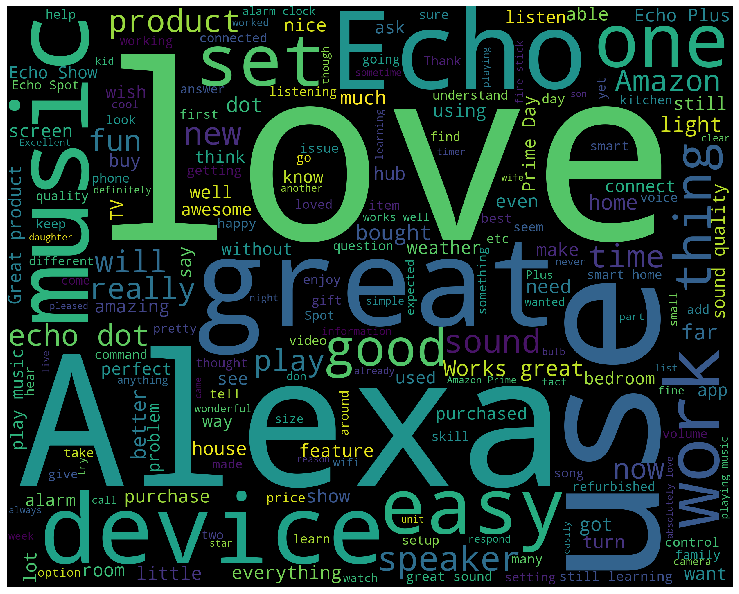

Negative Reviews


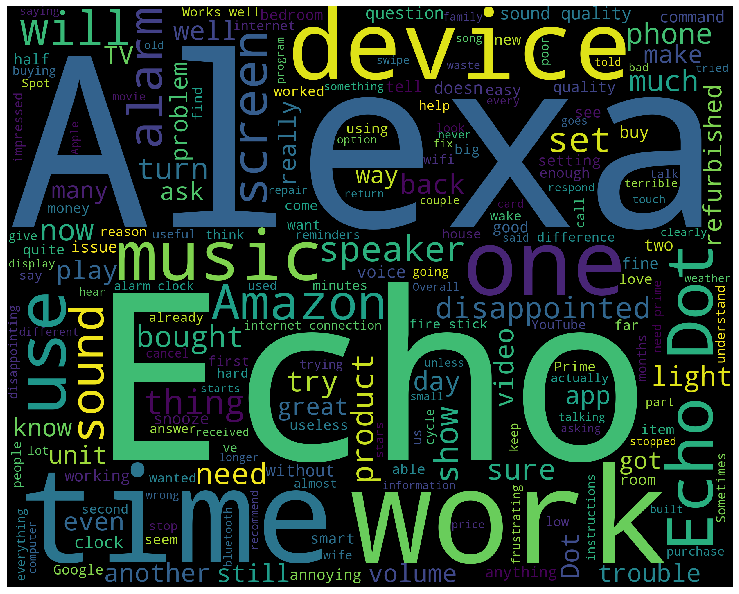

Neutral Reviews


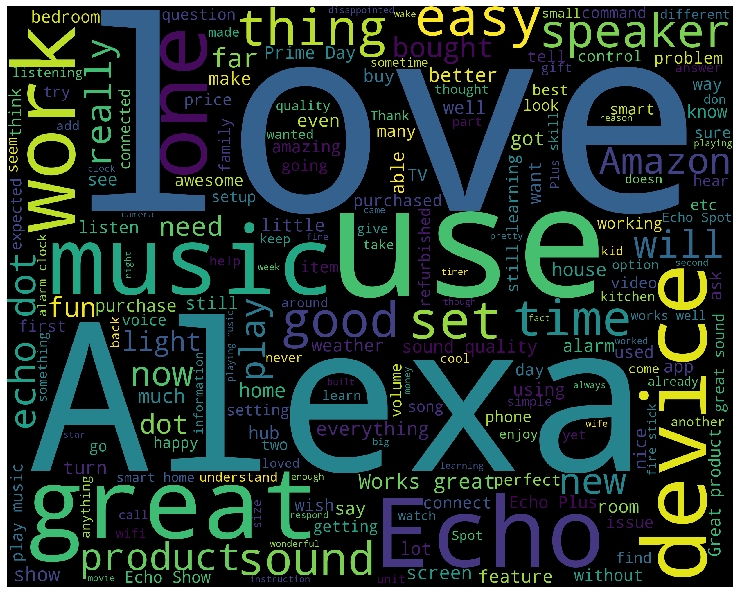

In [ ]:
def wordcloud_draw(list1, color = 'black'):
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(" ".join(list1))
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

print("Positive Reviews")
positive = result[result['feedbk'] == "positive"]
positive = positive['reviews']
wordcloud_draw(positive)
print("Negative Reviews")
negative = result[result['feedbk'] == "negative"]
negative = negative['reviews']
wordcloud_draw(negative)
print("Neutral Reviews")
neutral = result[result['feedbk'] == "neutral"]
neutral = result['reviews']
wordcloud_draw(neutral)

In [ ]:
# Cleaning the texts
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
corpus=[]
for i in range(0,3150):
    review = re.sub('[^a-zA-Z]', ' ', result['reviews'][i] )
    review=review.lower()
    review=review.split()
    ps=WordNetLemmatizer()
    review=[ps.lemmatize(word) for word in review if not word in set(stopwords.words('english'))]
    review=' '.join(review)
    corpus.append(review)

In [ ]:
# creating the Bag of words Model
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer(max_features=1500) #This will create Sparse Matrix
X=cv.fit_transform(corpus).toarray()
y=result.iloc[:,2].values
print(X)
print(y)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
['positive' 'positive' 'negative' ... 'positive' 'neutral' 'positive']


In [ ]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)


In [ ]:
# Fitting Random Forest classifier with 100 trees to the Training set
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 100, random_state = 0)
classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [ ]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)

In [ ]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix,classification_report



In [ ]:
cm=confusion_matrix(y_test, y_pred)
report=classification_report(y_test,y_pred)
print(cm)
print(report)

[[ 17   4  19]
 [  2  60  13]
 [  0  14 501]]
              precision    recall  f1-score   support

    negative       0.89      0.42      0.58        40
     neutral       0.77      0.80      0.78        75
    positive       0.94      0.97      0.96       515

    accuracy                           0.92       630
   macro avg       0.87      0.73      0.77       630
weighted avg       0.92      0.92      0.91       630



**By using Random Forest Classifier algorithm, we can observe the accuracy score is 0.92.**